In [69]:
%matplotlib inline
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob  
import imageio


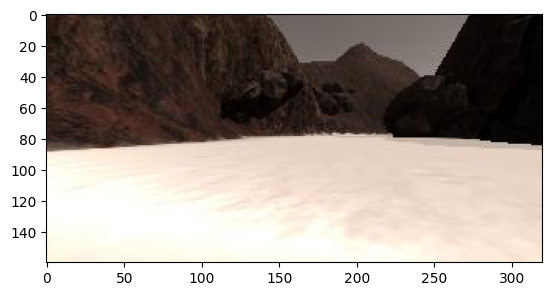

In [70]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

<h2>Calibration Data</h2>

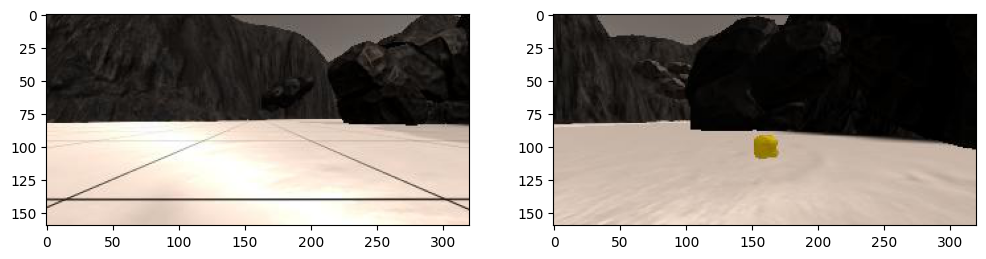

In [71]:
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)


<h2> Perspective Transform </h2>

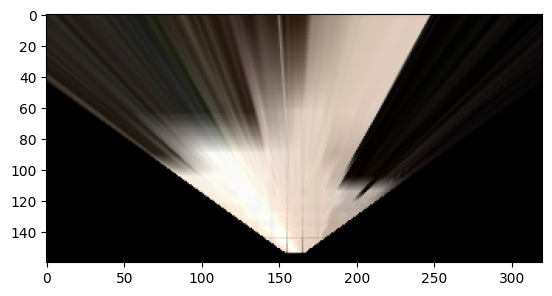

In [72]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped

dst_size = 5 
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                 [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                 [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                 [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                 ])
    
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

<h2> Color Thresholding </h2>

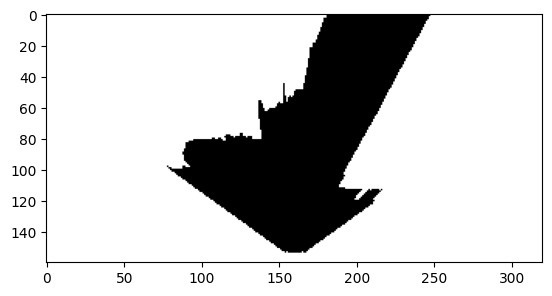

In [73]:
def color_thresh(img, rgb_thresh=(160, 160, 160), flag="navigable_terrain"):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    if flag == "navigable_terrain":
        above_thresh = (img[:, :, 0] > rgb_thresh[0]) \
                       & (img[:, :, 1] > rgb_thresh[1]) \
                       & (img[:, :, 2] > rgb_thresh[2])
        # Index the array of zeros with the boolean array and set to 1
        color_select[above_thresh] = 1
        return color_select
    elif flag == "obstacle":
        below_thresh = (img[:, :, 0] < rgb_thresh[0]) \
                       & (img[:, :, 1] < rgb_thresh[1]) \
                       & (img[:, :, 2] < rgb_thresh[2])
        # Index the array of zeros with the boolean array and set to 1
        color_select[below_thresh] = 1   
    # Return the binary image
    return color_select
navigable_map = color_thresh(warped)
obstacle_map = color_thresh(warped, flag="obstacle")
plt.imshow(navigable_map , cmap='gray')
plt.imshow(obstacle_map, cmap='gray')




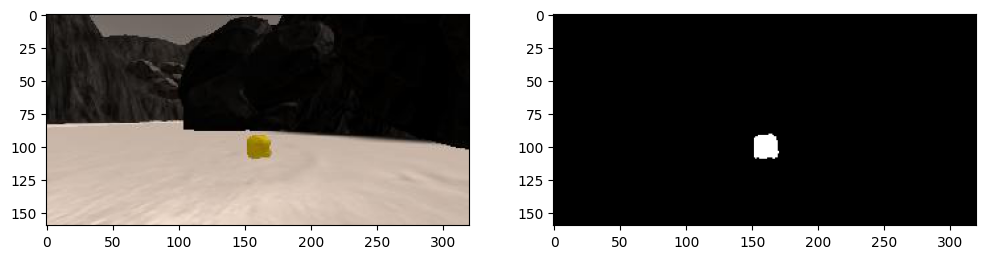

In [74]:
def rock_thresh(img):
    # Convert RGBto HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Define range of yellow colors in HSV
    lower_yellow = np.array([24-5, 100,100], dtype='uint8')
    upper_yellow = np.array([24+5, 255, 255], dtype='uint8')
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask 

rock_map = rock_thresh(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')


<h2>Coordinate Transformations </h2>

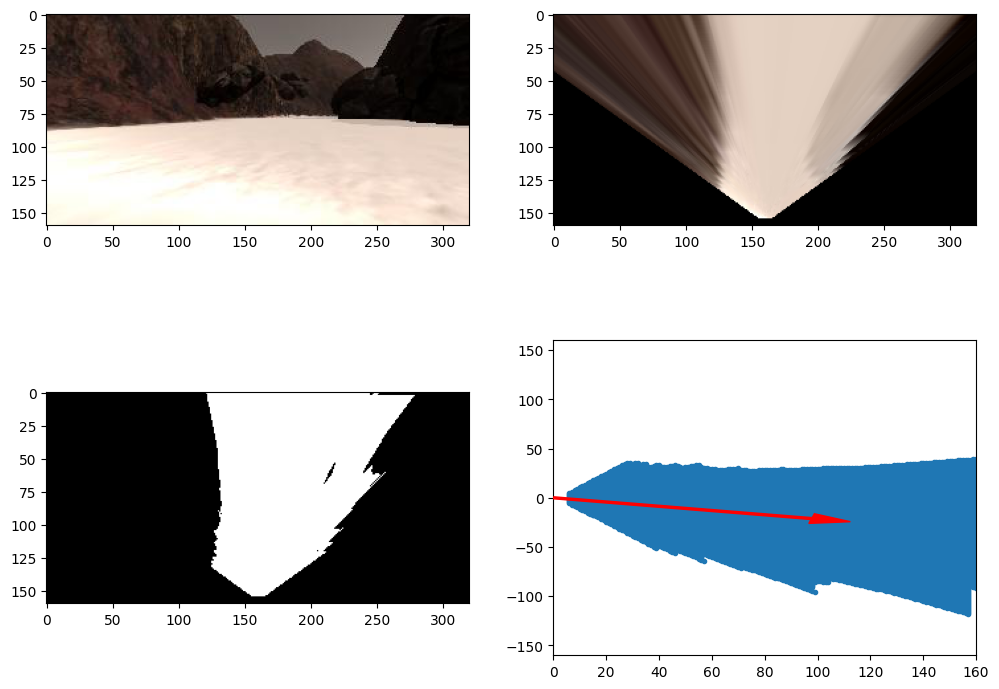

In [75]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=9, head_width=10, width=2)


<h2> Read in saved data and ground truth map of the world </h2>

In [76]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist()
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
data = Databucket()

<h2> Write a function to process stored images </h2>

In [81]:
def process_image(img):
    
    # 1) Define source and destination points for perspective transform
    dst_size = 5 
        # Set a bottom offset to account for the fact that the bottom of the image 
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)

    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = color_thresh(warped)
    navigable[0:int(navigable.shape[0]/2),:] = 0  # ignore half of the image as bad data
        # Obstacles are simply navigable inverted
    mask = np.ones_like(navigable)
    mask[:,:] = 255
    mask = perspect_transform(mask, source, destination)
    obstacles = np.absolute((np.float32(threshed)-1) * mask)
    obstacles[0:int(obstacles.shape[0]/2),:] = 0  # ignore half of the image as bad data
        #identify the rock
    lower_yellow = np.array([24-10,100,100])
    upper_yellow = np.array([24+10,255,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # Threshold the HSV image to get only upper_yellow colors
    rock_samples = cv2.inRange(hsv, lower_yellow, upper_yellow)
    rock_samples = perspect_transform(rock_samples, source, destination)

    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix_navigable, ypix_navigable = rover_coords(navigable)
    xpix_obstacles, ypix_obstacles = rover_coords(obstacles)
    xpix_rocks, ypix_rocks = rover_coords(rock_samples)
    # 5) Convert rover-centric pixel values to world coords
    scale = 2 * dst_size
    navigable_x_world, navigable_y_world = pix_to_world(xpix_navigable, ypix_navigable, 
                                                        data.xpos[data.count], data.ypos[data.count], 
                                                        data.yaw[data.count], data.worldmap.shape[0], scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(xpix_obstacles, ypix_obstacles, 
                                                      data.xpos[data.count], data.ypos[data.count], 
                                                      data.yaw[data.count], data.worldmap.shape[0], scale)
    rock_x_world, rock_y_world = pix_to_world(xpix_rocks, ypix_rocks, 
                                              data.xpos[data.count], data.ypos[data.count], 
                                              data.yaw[data.count], data.worldmap.shape[0], scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 10
    data.worldmap[rock_y_world, rock_x_world, 1] = 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 10
    # remove overlap mesurements
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix, 0] = 0
    # clip to avoid overflow
    data.worldmap = np.clip(data.worldmap, 0, 255)
    
    # 7) Make a mosaic image
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    warped = perspect_transform(img, source, destination)
    output_image[0:img.shape[0], img.shape[1]:] = warped
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
    # worldmap
    output_image[img.shape[0]:, img.shape[1]:-120] = np.flipud(data.worldmap)

        # Then putting some text over the image
    cv2.putText(output_image,"The output pipeline", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

<h2> Make a video from processed image data</h2>

In [83]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/pipeline_vedio.mp4'
data = Databucket() 
clip = ImageSequenceClip(data.images, fps=60) #video will be sped up because recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #this function expects color images
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/pipeline_vedio.mp4.
Moviepy - Writing video ../output/pipeline_vedio.mp4



Moviepy - Done !
Moviepy - video ready ../output/pipeline_vedio.mp4
CPU times: user 1.77 s, sys: 34.1 ms, total: 1.81 s
Wall time: 1.95 s
